## Preface

Much of the section here requires the knowledge of a flotation plant process and possibly the input of an SME. Therefore, the full solution to the optimization problem might not be accurate for prescriptive analytics since its accuracy beyond the scope of this project. However, the following is a brief overview of the problem and the approach to solving. One major thing to note is that the majority of the solution is based on the assumption of the flotation process given the data provided


In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

## Control Variables

The following variables are assumed to be within the control of the plant enginer as they are being fed manually into the flotation plant and are not the result of a byproduct process: 
- air flow rate  
- amina flow 
- starch flow
- Ore pulp ph, density and flow 

As it has been shown in the EDA section (2.eda_feature_engineer.ipynb), the mean value of % Silica in June has been shown to be the lowest throughout the year. Therefore, the data from June will be used to optimize the flotation plant process.

Text(0, 0.5, 'Average % Silica Concentrate')

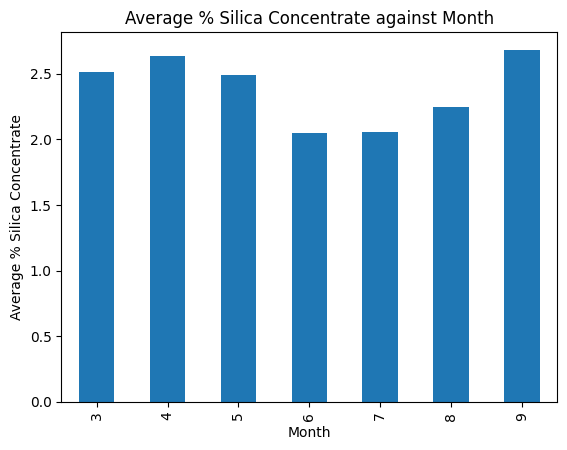

In [4]:
# Load the data
df = pd.read_csv("../data/MiningProcess_Flotation_Plant_Database.csv")
df.head()

# Convert the date column to datetime
df2 = df.copy()
df2["date"] = pd.to_datetime(df2["date"], format="%Y-%m-%d %H:%M:%S")

# Set the date as the index
df2.set_index("date", inplace=True)

# Convert ',' to '.' and convert to float
for col in df2.columns:
    df2[col] = df2[col].str.replace(",", ".").astype(float)

df2.head()

df4 = df2.copy()

# Reset the index of df4
df4.reset_index(inplace=True)

# Create a new column called 'month' and store the month of the date in it
df4["month"] = df4["date"].dt.month

# Plot the average % Silica Concentrate against the month
df4.groupby("month")["% Silica Concentrate"].mean().plot(kind="bar")
plt.title("Average % Silica Concentrate against Month")
plt.xlabel("Month")
plt.ylabel("Average % Silica Concentrate")

## Upper and Lower Bounds for Control Variables

The upper and lower bounds for the control variables then defined within 1st and 3rd quartiles of the data, as anything beyond the range would be considered as an outlier. This gives us a range of values that are optimized for the minimizing the % Silica in the concentrate in the flotation plant.

In [5]:
# Store the control variables in a list
control_variables = ["Starch Flow", "Amina Flow", "Ore Pulp Flow", "Flotation Column 01 Air Flow", "Flotation Column 02 Air Flow", "Flotation Column 03 Air Flow", "Flotation Column 04 Air Flow", "Flotation Column 05 Air Flow", "Flotation Column 06 Air Flow", "Flotation Column 07 Air Flow"]

# Loop through the control variables and store the 1st and 3rd quartiles in a dictionary
quartiles_general = {}
for var in control_variables:
    quartiles_general[var] = [df4[var].quantile(0.25), df4[var].quantile(0.75)]

# The left side of the dictionary is the 1st quartile and the right side is the 3rd quartile, which represents the minimum and maximum values of the control variables
print(quartiles_general)

{'Starch Flow': [2076.32, 3727.73], 'Amina Flow': [431.796, 553.257], 'Ore Pulp Flow': [394.264, 402.968], 'Flotation Column 01 Air Flow': [250.281, 300.149], 'Flotation Column 02 Air Flow': [250.457, 300.69], 'Flotation Column 03 Air Flow': [250.855, 300.382], 'Flotation Column 04 Air Flow': [298.2625661157, 300.638], 'Flotation Column 05 Air Flow': [298.068, 301.7911370745], 'Flotation Column 06 Air Flow': [262.541, 303.061], 'Flotation Column 07 Air Flow': [256.302, 301.904]}


In [16]:
# Create a copy of df4 and filter the data to June only
df5 = df4.copy()
df5 = df5[df5["month"] == 6]

# Loop through the control variables and store the 1st and 3rd quartiles in a dictionary
quartiles_june = {}
for var in control_variables:
    quartiles_june[var] = [df5[var].quantile(0.25), df5[var].quantile(0.75)]

# The left side of the dictionary is the 1st quartile and the right side is the 3rd quartile, which represents the minimum and maximum values of the control variables. Loop through quartiles_june and print the values

for key, value in quartiles_june.items():
    print(key, value)



Starch Flow [2541.6724999999997, 3867.7850000000003]
Amina Flow [450.73776344085, 572.96525]
Ore Pulp Flow [397.367, 402.959]
Flotation Column 01 Air Flow [299.31, 300.508]
Flotation Column 02 Air Flow [289.664, 301.485]
Flotation Column 03 Air Flow [298.674, 301.025]
Flotation Column 04 Air Flow [299.31, 300.494]
Flotation Column 05 Air Flow [298.33175, 301.23525]
Flotation Column 06 Air Flow [297.08, 301.497]
Flotation Column 07 Air Flow [298.337, 301.245]


In conclusion, the limits shown above will be set as the upper and lower bounds for the control variables to minimize the % Silica in the concentrate in the flotation plant as much as possible

## Soft Sensors for Non-Control Variables

The following values are set prior to the flotation plant process (% Silica Feed, % Iron Feed, Ore Pulp pH, Ore Pulp Density) and will remain consistent throughout the entire optimization process. 

The froth level in the columns (Flotation Column 01 Level - Flotation Column 07 Level) are the byproduct of the flotation process and not within the plant engineer's direct control. Nevertheless in this project, it will be treated as a "soft-sensor" that is continuously fed into the optimizer for recommendations. 

In [23]:
fed_once = ["% Silica Feed", "% Iron Feed", "Ore Pulp pH", "Ore Pulp Density"]
# Loop through the fed_once list and store them in a dictionary
means_fed_once = {}
for var in fed_once:
    means_fed_once[var] = df5[var].mean()

for key, value in means_fed_once.items():
    print(key, value)

non_control_variables = ["Flotation Column 01 Level","Flotation Column 02 Level","Flotation Column 03 Level","Flotation Column 04 Level","Flotation Column 05 Level","Flotation Column 06 Level","Flotation Column 07 Level"]

# Loop through the non_control_variables list and store them in a dictionary
means_non_control_variable= {}
for var in non_control_variables:
    means_non_control_variable[var] = df5[var].mean()

for key, value in means_non_control_variable.items():
    print(key, value)


% Silica Feed 12.940180555555555
% Iron Feed 58.11804166666667
Ore Pulp pH 9.788932363271606
Ore Pulp Density 1.664776049305556
Flotation Column 01 Level 469.65211534722226
Flotation Column 02 Level 469.44673393132723
Flotation Column 03 Level 485.6843682060186
Flotation Column 04 Level 443.3921655825618
Flotation Column 05 Level 447.113067021605
Flotation Column 06 Level 452.3420182214507
Flotation Column 07 Level 446.4298390740741


We will be using the values shown above to test our optimizer

## Running the Optimizer using Scipy

In [8]:
from scipy.optimize import differential_evolution
import pickle

model = pickle.load(open("../models/silica_model.pkl", "rb"))


In [9]:
def obj_fun(X):
    X = [X]
    results = model.predict(X)
    return results


In [24]:
boundaries = [
    (12.94, 12.94),  # % Silica Feed
    (58.12, 58.12),  # % Iron Feed
    (2541.67, 3867.79),  # Starch Flow
    (450.74, 572.97),  # Amina Flow
    (397.37, 402.96),  # Ore Pulp Flow
    (9.79, 9.79),  # Ore Pulp pH
    (1.67, 1.67),  # Ore Pulp Density
    (299.31, 300.51),  # Flotation Column 01 Air Flow
    (289.67, 301.49),  # Flotation Column 02 Air Flow
    (298.67, 301.03),  # Flotation Column 03 Air Flow
    (299.31, 300.49),  # Flotation Column 04 Air Flow
    (298.33, 301.24),  # Flotation Column 05 Air Flow
    (297.08, 301.50),  # Flotation Column 06 Air Flow
    (298.33, 301.25),  # Flotation Column 07 Air Flow
    (469.65, 469.65),  # Flotation Column 01 Level
    (469.45, 469.45),  # Flotation Column 02 Level
    (485.68, 485.68),  # Flotation Column 03 Level
    (443.39, 443.39),  # Flotation Column 04 Level
    (447.11, 447.11),  # Floation Column 05 Level
    (452.34, 452.34),  # Floation Column 06 Level
    (446.43, 446.43),  # Floation Column 07 Level
]
opt_results = differential_evolution(obj_fun, boundaries)

[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min

In [25]:
print(f"% Silica Feed: {opt_results.x[0]}")
print(f"% Iron Feed: {opt_results.x[1]}")
print(f"Starch Flow: {opt_results.x[2]}")
print(f"Amina Flow: {opt_results.x[3]}")
print(f"Ore Pulp Flow: {opt_results.x[4]}")
print(f"Ore Pulp pH: {opt_results.x[5]}")
print(f"Ore Pulp Density: {opt_results.x[6]}")
print(f"Flotation Column 01 Air Flow: {opt_results.x[7]}")
print(f"Flotation Column 02 Air Flow: {opt_results.x[8]}")
print(f"Flotation Column 03 Air Flow: {opt_results.x[9]}")
print(f"Flotation Column 04 Air Flow: {opt_results.x[10]}")
print(f"Flotation Column 05 Air Flow: {opt_results.x[11]}")
print(f"Flotation Column 06 Air Flow: {opt_results.x[12]}")
print(f"Flotation Column 07 Air Flow: {opt_results.x[13]}")
print(f"Flotation Column 01 Level: {opt_results.x[14]}")
print(f"Flotation Column 02 Level: {opt_results.x[15]}")
print(f"Flotation Column 03 Level: {opt_results.x[16]}")
print(f"Flotation Column 04 Level: {opt_results.x[17]}")
print(f"Flotation Column 05 Level: {opt_results.x[18]}")
print(f"Flotation Column 06 Level: {opt_results.x[19]}")
print(f"Flotation Column 07 Level: {opt_results.x[20]}")
print(f"Predicted % Silica Concentrate: {opt_results.fun}")


% Silica Feed: 12.94
% Iron Feed: 58.12
Starch Flow: 3017.32208573954
Amina Flow: 557.2585782314287
Ore Pulp Flow: 399.16944453685664
Ore Pulp pH: 9.79
Ore Pulp Density: 1.67
Flotation Column 01 Air Flow: 299.43981469589033
Flotation Column 02 Air Flow: 291.3671520065686
Flotation Column 03 Air Flow: 299.541895388772
Flotation Column 04 Air Flow: 300.20011096679076
Flotation Column 05 Air Flow: 300.054194219347
Flotation Column 06 Air Flow: 300.17980403669816
Flotation Column 07 Air Flow: 298.57715976556096
Flotation Column 01 Level: 469.65
Flotation Column 02 Level: 469.45
Flotation Column 03 Level: 485.68
Flotation Column 04 Level: 443.39
Flotation Column 05 Level: 447.11
Flotation Column 06 Level: 452.34
Flotation Column 07 Level: 446.43
Predicted % Silica Concentrate: 1.8024327785319065


In [27]:
# Optimal Values for the control variables
optimal_values = {
    "Starch Flow": opt_results.x[2],
    "Amina Flow": opt_results.x[3],
    "Ore Pulp Flow": opt_results.x[4],
    "Flotation Column 01 Air Flow": opt_results.x[7],
    "Flotation Column 02 Air Flow": opt_results.x[8],
    "Flotation Column 03 Air Flow": opt_results.x[9],
    "Flotation Column 04 Air Flow": opt_results.x[10],
    "Flotation Column 05 Air Flow": opt_results.x[11],
    "Flotation Column 06 Air Flow": opt_results.x[12],
    "Flotation Column 07 Air Flow": opt_results.x[13]
}
# Loop through the optimal_values and print the optimal values
for key, value in optimal_values.items():
    print(f"{key}: {value}")


Starch Flow: 3017.32208573954
Amina Flow: 557.2585782314287
Ore Pulp Flow: 399.16944453685664
Flotation Column 01 Air Flow: 299.43981469589033
Flotation Column 02 Air Flow: 291.3671520065686
Flotation Column 03 Air Flow: 299.541895388772
Flotation Column 04 Air Flow: 300.20011096679076
Flotation Column 05 Air Flow: 300.054194219347
Flotation Column 06 Air Flow: 300.17980403669816
Flotation Column 07 Air Flow: 298.57715976556096


In [30]:
# Find the minimum and maximum values of % Silica Concentrate
min_silica = df4["% Silica Concentrate"].min()
max_silica = df4["% Silica Concentrate"].max()
optimized_silica = opt_results.fun

# Print the minimum and maximum values of % Silica Concentrate
print(f"Minimum % Silica Concentrate: {min_silica}")
print(f"Maximum % Silica Concentrate: {max_silica}")

# Print the optimized value of % Silica Concentrate
print(f"Optimized % Silica Concentrate: {optimized_silica}")

Minimum % Silica Concentrate: 0.6
Maximum % Silica Concentrate: 5.53
Optimized % Silica Concentrate: 1.8024327785319065


Conclusion: The optimizer will be run with the control variables set within the upper and lower bounds and the soft sensors set to the values shown above. The optimizer will then return the optimal values for the control variables to minimize the % Silica in the concentrate in the flotation plant as much as possible. From there, the plant engineer can then use the optimal values to adjust the flotation plant process accordingly.